# Preamble

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import pickle
import matplotlib.colors as colors
import datetime as dt
import pickle
from matplotlib.colors import BoundaryNorm
import glob
import pdb
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

import calendar
import sys
sys.path.append('/home/563/ab2313/MJO/functions')
import access_functions as af
import subphase_calc_functions as subphase_calc
import access_plot_functions as apf
import load_dataset as load
import phase_calc_functions as phase_calc
from importlib import reload

import subphase_calc_2 as sub2

In [2]:
load = reload(load)
awap, access, rmm_obs, rmm_access = load.load_accessifies_variables2()

# AWAP Calculations

Splitting the normal events

In [3]:
subphase_calc = reload(subphase_calc)
# Split AWAP into the subphases: enhanced, suppressed, transition and inactive.
awap_split = subphase_calc.split_into_subphase(awap, rmm_obs)

In [4]:
sub2 = reload(sub2)
# The number of raindays/ the total number of daus (*100): percent of days as raindays
awap_count, awap_anomaly =\
        sub2.count_and_anomly_month_subphase(awap_split, awap, 
                                    rmm_obs)

Getting the extreme events

In [5]:
import subphase_calc_functions as scf

In [6]:
awap_90 = scf.unsplit_find_events_above_q(awap, 90)

In [7]:
awap_90_split = subphase_calc.split_into_subphase(awap_90, rmm_obs)

In [8]:
sub2 = reload(sub2)
awap_count_90, awap_anomaly_90 =\
            sub2.extreme_count_and_anomly_month_subphase(awap_90_split, awap_90, 
                                                             awap_split, awap, climatology = 0)

In [9]:
# sub2 = reload(sub2)
# awap_count_90, awap_anomaly_90 =\
#         sub2.count_and_anomly_month_subphase(awap_90_split, awap_90, 
#                                     rmm_obs)

# Extreme Rainfall

## ACCESS Calculations

In [37]:
sub2 = reload(sub2)
af = reload(af)


q = 90

count_stor_90 = []
anom_stor_90 = []
    
# Looping through ensemble
for ensemble in access.ensemble.values:
    
    # Selecting a single ensemble
    access_single = access.sel(ensemble = ensemble)
    rmm_single = rmm_access.sel(ensemble = ensemble)
    
    # Getting extrreme events
    access_90_single = scf.unsplit_find_events_above_q(access_single, 90)
    
    
    # Splitting the rainfall in to the 9 mjo phases
    access_90_split = subphase_calc.split_into_subphase(access_90_single, rmm_single)
    access_split = subphase_calc.split_into_subphase(access_single, rmm_single)
    
    # Calculating the index for a single ensemble
    access_count_norm_single_90, access_anomaly_norm_single_90 = \
                sub2.extreme_count_and_anomly_month_subphase(access_90_split, access_90_single, 
                                                             access_split, access_single, climatology = 0)
    
    
    count_stor_90.append(access_count_norm_single_90)
    
    # For some reason the 11th ensebmle maintain the ensemble dimensin (???)
#     if ensemble == 11:
#         access_anomaly_norm_single = access_anomaly_norm_single.drop('ensemble')
    
    anom_stor_90.append(access_anomaly_norm_single_90)

    
    
# Storing all the results in a xarray files.
access_count_total_90 = xr.concat(count_stor_90, dim = 'ensemble')
access_anom_total_90 = xr.concat(anom_stor_90, dim = 'ensemble')

In [38]:
# Taking the mean across all ensembles

access_count_mean_90 = access_count_total_90.mean(dim = 'ensemble').compute()

access_anom_mean_90 = access_anom_total_90.mean(dim = 'ensemble').compute()

## Map Plots

### Climatology

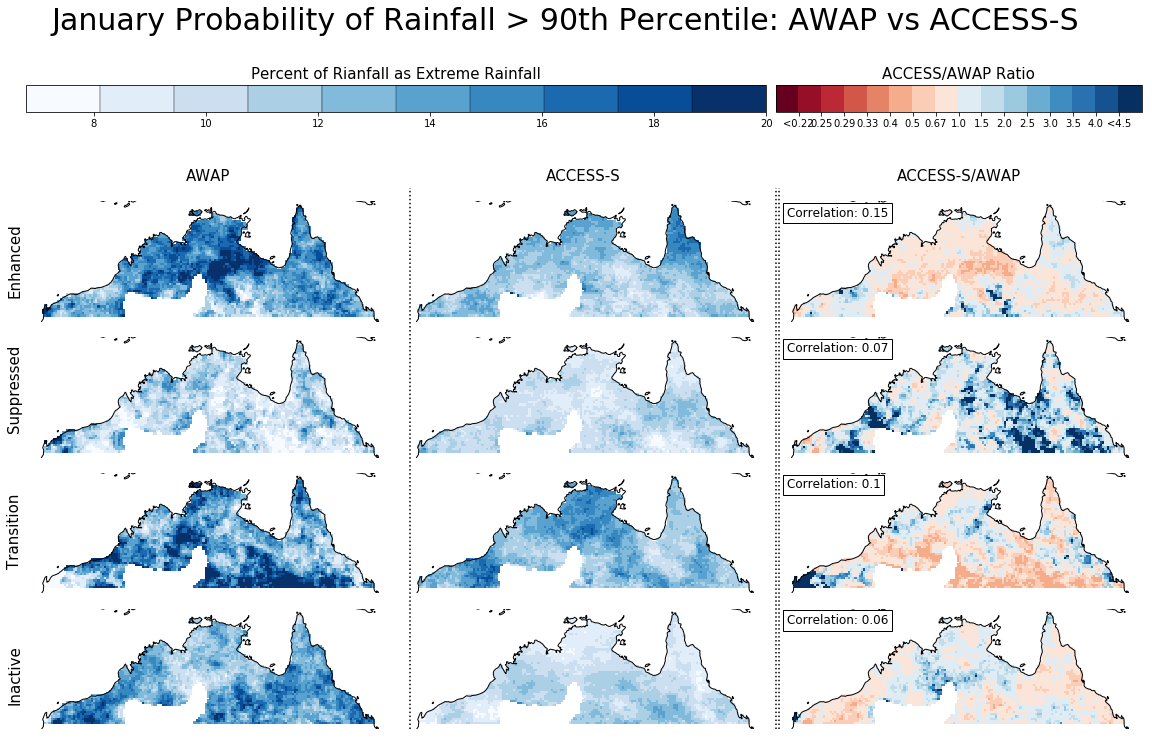

In [14]:
apf = reload(apf) 
apf.comparison_plot(awap_count_90, access_count_mean_90, month = 1,
                    plot_max = 20,  vmax = 5, add_white = 0,
                    rain_type = 'Probability of Rainfall > 90th Percentile',
                   cbar1_title = 'Percent of Rianfall as Extreme Rainfall', cbar2_title = 'ACCESS/AWAP Ratio',
                    savedir = savedir, savefig = 0
                  )

### Anomaly

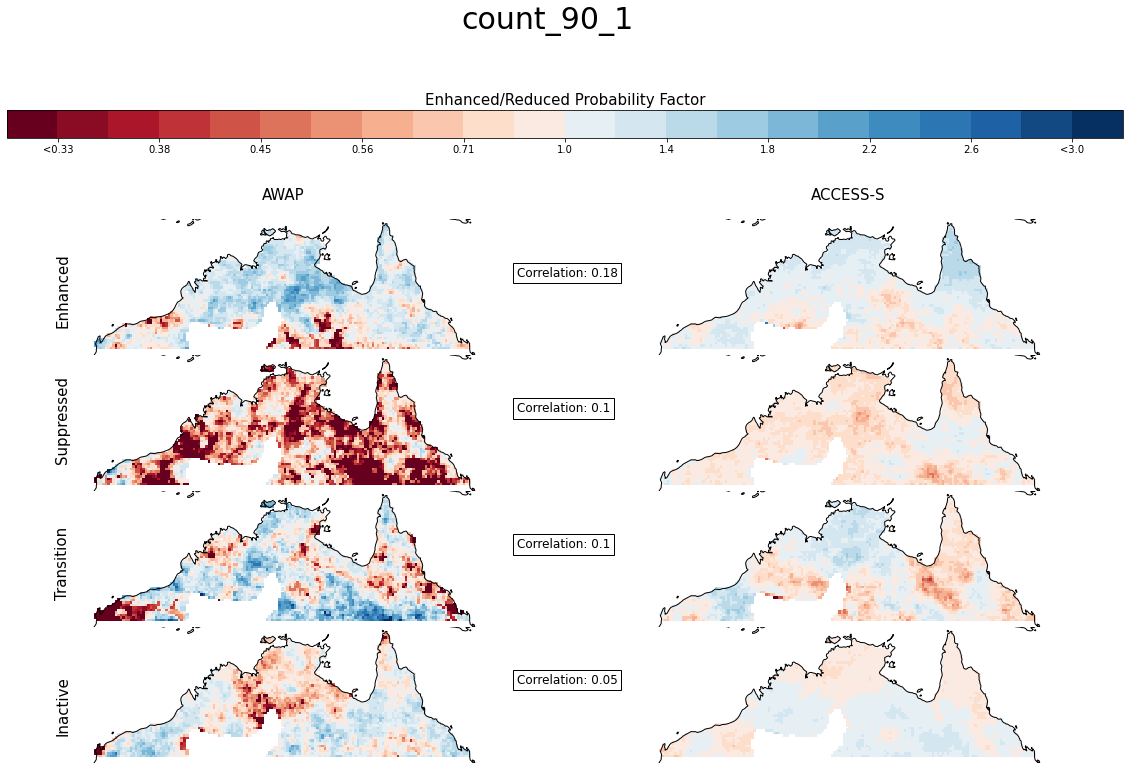

In [20]:
apf = reload(apf)
month = 1
apf.anomaly_plot_subphases(awap_anomaly_90,access_anom_mean_90 , month = month
                          ,vmax = 3.2, cbar_title = 'Enhanced/Reduced Probability Factor',
                          savename = f'count_90_{month}')

In [39]:
savedir = '../images/access/pattern_correlation/'

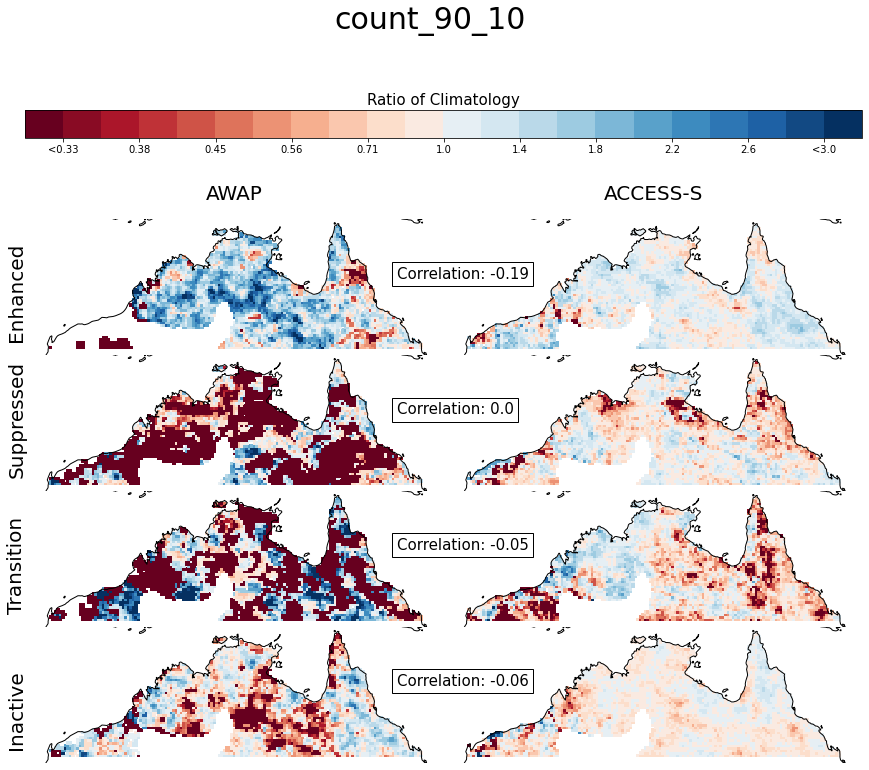

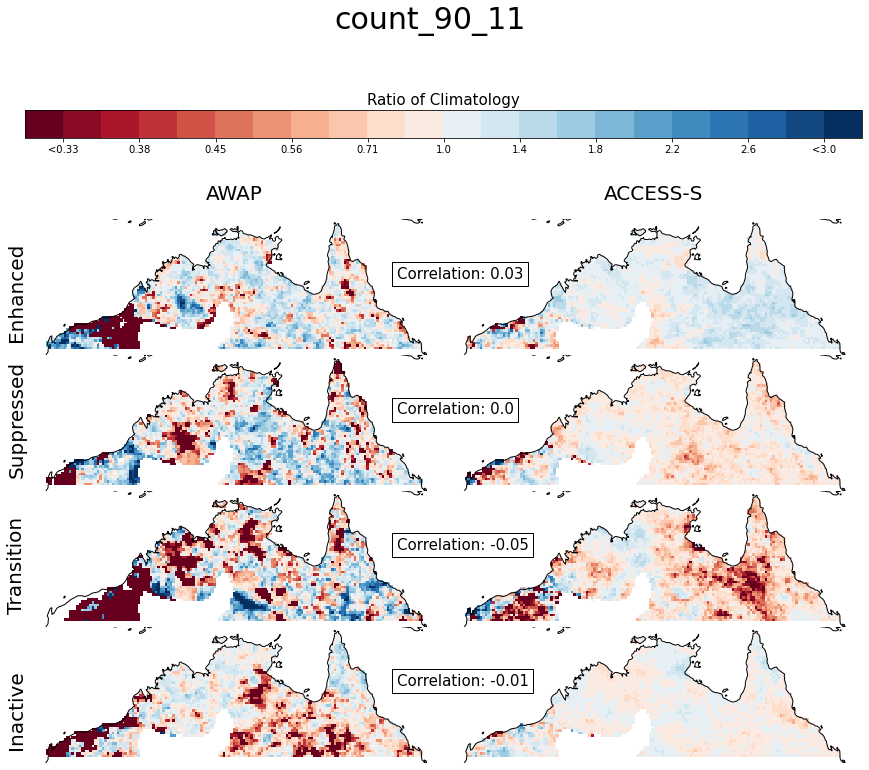

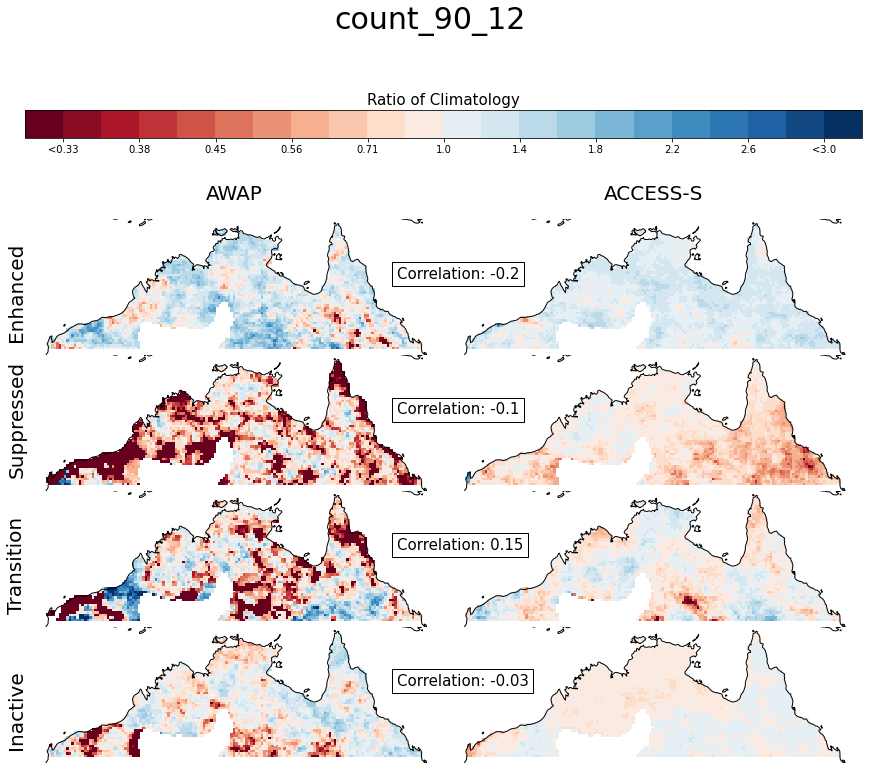

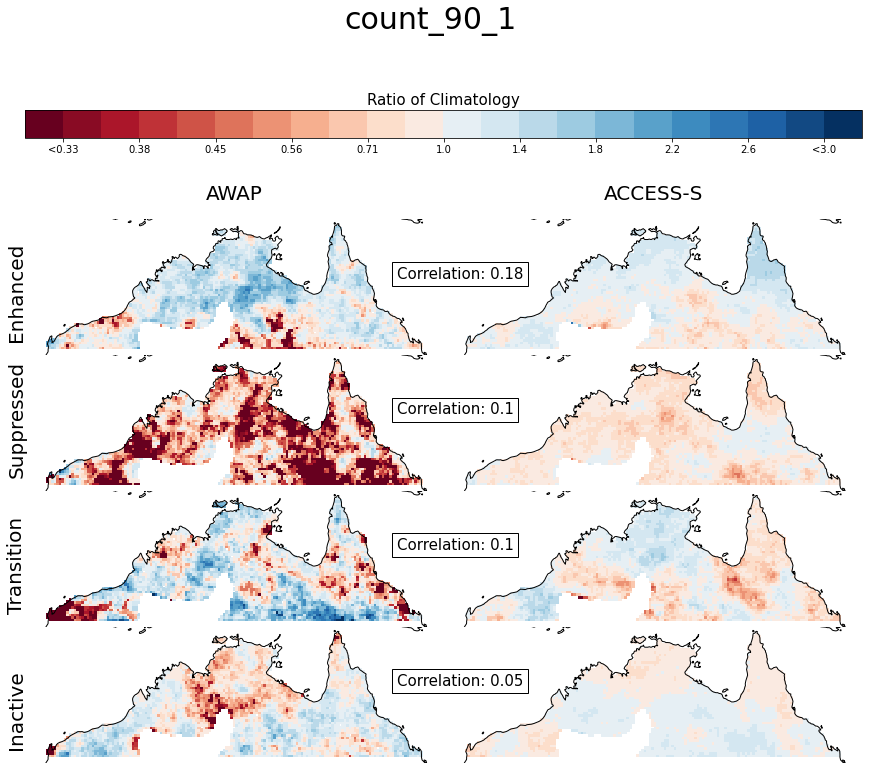

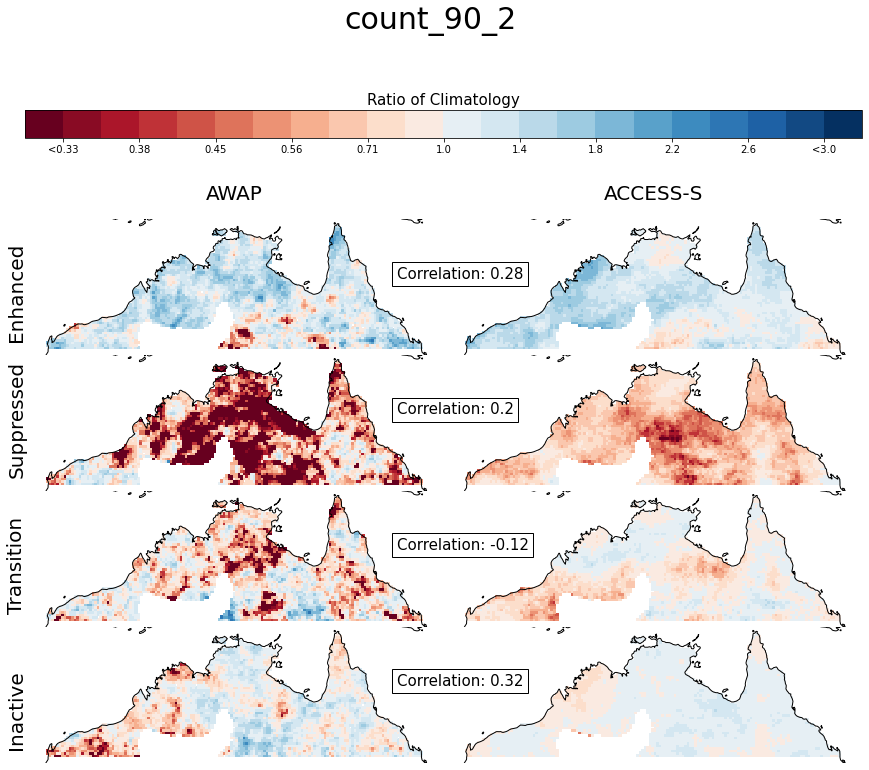

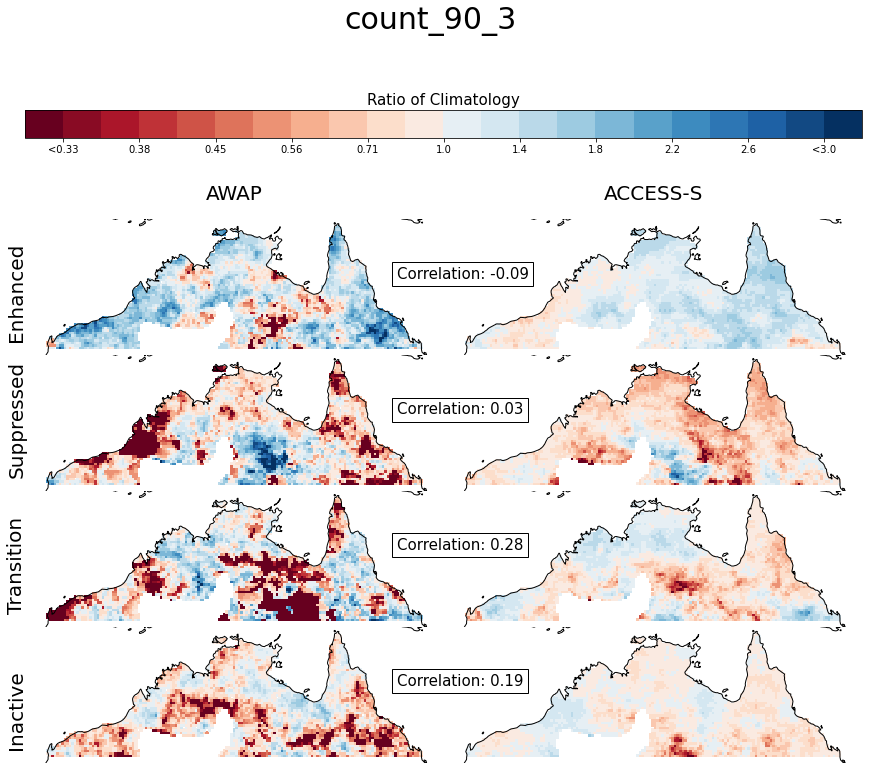

In [40]:
for month in [10,11,12,1,2,3]:
    apf.anomaly_plot_subphases(awap_anomaly_90,access_anom_mean_90 , month = month
                              ,vmax = 3.2, cbar_title = 'Ratio of Climatology',
                              savename = f'count_90_{month}', savedir =  savedir)

## Timeseries Correlations

### Climatology

In [22]:
af = reload(af)
pattern_correlation_90 = af.month_pattern_correlations(awap_count_90, access_count_mean_90)

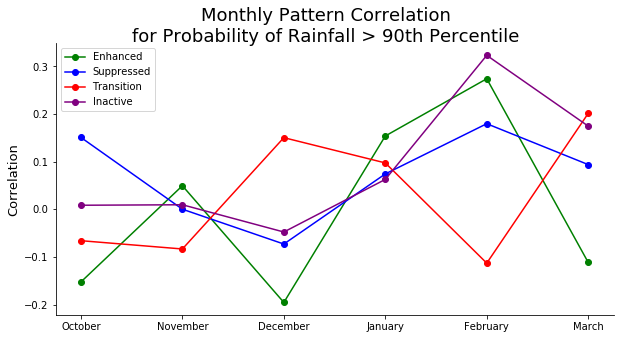

In [20]:
apf = reload(apf)

title = 'Monthly Pattern Correlation\nfor Probability of Rainfall > 90th Percentile'

apf.timeseries_pattern_correlation_plot(pattern_correlation_90,title = title, custom  = 0, 
                                        savefig = 1, savedir = savedir)

In [23]:
af = reload(af)
ensemble_raw_correlation_90 = af. list_pattern_correlation(awap_count_90, count_stor_90)

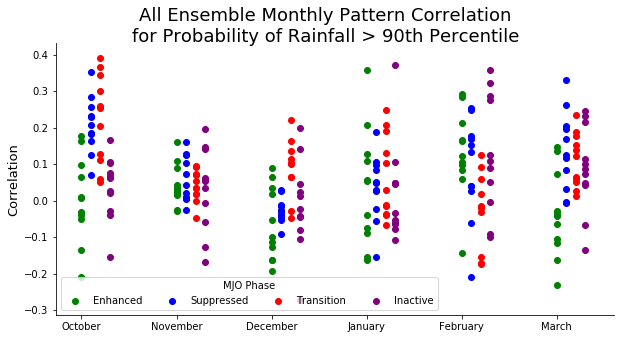

In [25]:
afp2 = reload(afp2)

title = 'All Ensemble Monthly Pattern Correlation\nfor Probability of Rainfall > 90th Percentile'
afp2.stacked_patter_correlation_timeseries(ensemble_raw_correlation_90, title = title,
                                           savefig = 1, savedir = savedir)

### Anomalies

In [24]:
af = reload(af)
anomaly_patterns_90 = af.month_pattern_correlations(awap_anomaly_90,access_anom_mean_90)

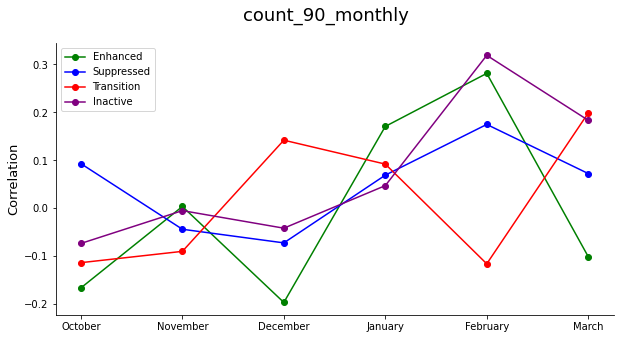

In [35]:
apf = reload(apf)

savename = 'count_90_monthly'

apf.timeseries_pattern_correlation_plot(anomaly_patterns_90,
                                        custom  = 0, 
                                        savename = savename, savedir = savedir)

<br>
Correlation of the raw count index with awap
<br> <br>
<br>


In [36]:
import access_plot_functions_2 as afp2

In [37]:
af = reload(af)
ensemble_anom_correlation_90 = af. list_pattern_correlation(awap_anomaly_90, anom_stor_90)

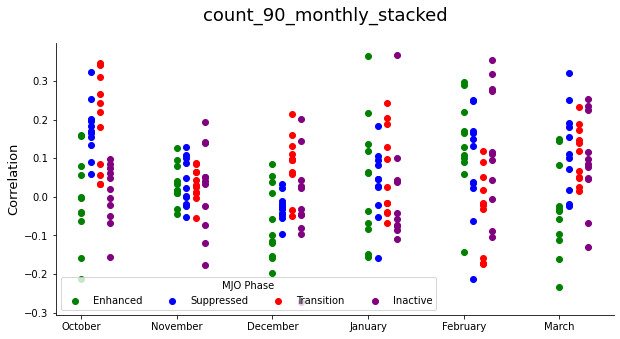

In [41]:
afp2 = reload(afp2)
savename = 'count_90_monthly_stacked'

afp2.stacked_patter_correlation_timeseries(ensemble_anom_correlation_90, savename = savename,
                                        savedir = savedir)

## Heatmaps

In [18]:
import access_heatmaps_corr as heat_corr

In [19]:
heat_corr = reload(heat_corr)

count_pcorr_90_state = heat_corr.pattern_corr_state(awap_anomaly_90,access_anom_mean_90)

In [20]:
count_pcorr_90_state.to_netcdf('/g/data/w40/ab2313/pattern_correlations/count_pattern_correlation_90.nc')

In [102]:
count_pcorr_90_state 

<xarray.Dataset>
Dimensions:      (month: 6, phase: 4, state: 4)
Coordinates:
  * phase        (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * month        (month) int64 10 11 12 1 2 3
  * state        (state) object 'All' 'WA' 'NT' 'QLD'
Data variables:
    correlation  (month, phase, state) float64 -0.1658 -0.3262 ... 0.1801 0.2337
    pval         (month, phase, state) float64 9.023e-20 1.787e-15 ... 2.494e-16

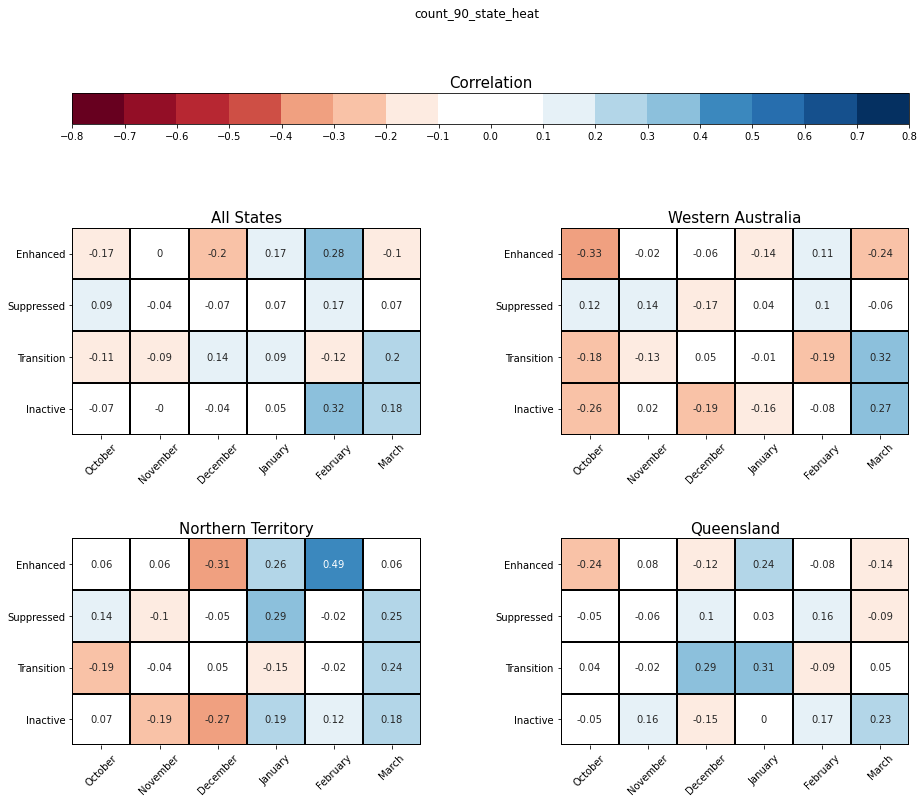

In [136]:
heat_corr = reload(heat_corr)
heat_corr.corr_heatmap_state_group(count_pcorr_90_state.correlation.transpose(), month_reverse = 0
                 , vmax = 0.8,step = 0.1, add_white = 1,
                 savename = 'count_90_state_heat', savedir = savedir)

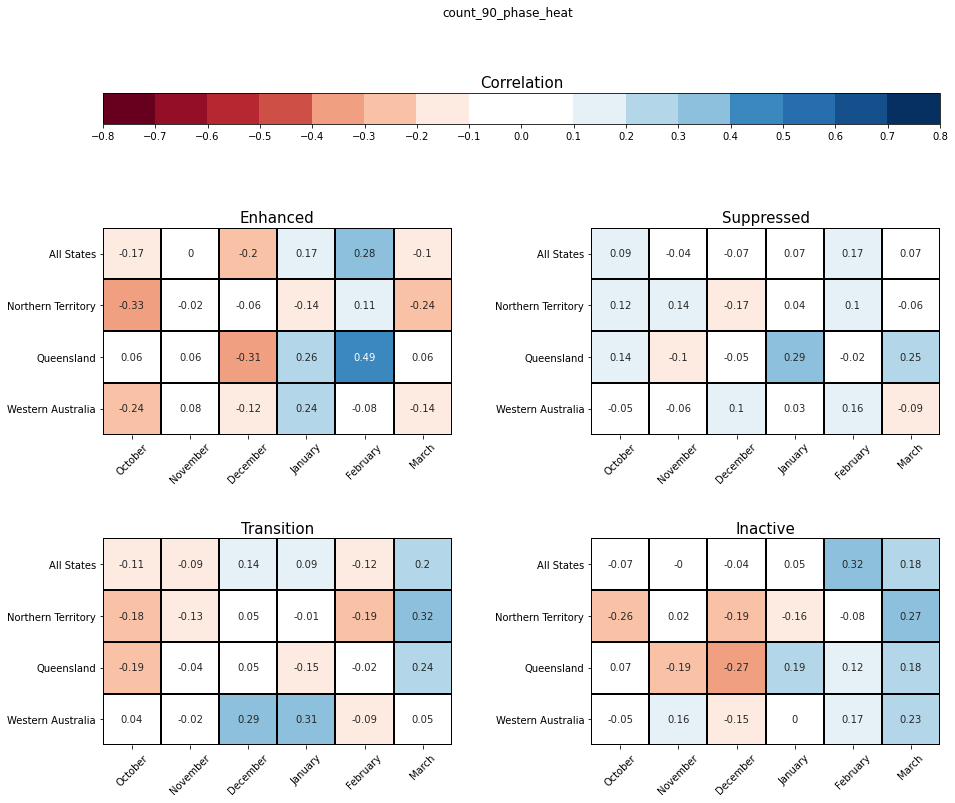

In [137]:
heat_corr = reload(heat_corr)
heat_corr.corr_heatmap_phase_group(count_pcorr_90_state.correlation.transpose(), month_reverse = 0
                 , vmax = 0.8,step = 0.1, add_white = 1,
                 savename = 'count_90_phase_heat', savedir = savedir)

# All Events

## ACCESS Calculations

In [9]:
sub2 = reload(sub2)
awap_count, awap_anomaly =\
        sub2.count_and_anomly_month_subphase(awap_split, awap, 
                                    rmm_obs)

In [10]:
sub2 = reload(sub2)
af = reload(af)

count_stor = []
anom_stor = []
    
# Looping through ensemble
for ensemble in access.ensemble.values:
    
    # Selecting a single ensemble
    access_single = access.sel(ensemble = ensemble)
    rmm_single = rmm_access.sel(ensemble = ensemble)
    
    # Splitting the rainfall in to the 9 mjo phases
    access_split = subphase_calc.split_into_subphase(access_single, rmm_single)
    
    # Calculating the index for a single ensemble
    access_count_norm_single, access_anomaly_norm_single = \
                sub2.count_and_anomly_month_subphase(access_split, access_single, 
                                        rmm_single)
    
    
    count_stor.append(access_count_norm_single)
    
    # For some reason the 11th ensebmle maintain the ensemble dimensin (???)
#     if ensemble == 11:
#         access_anomaly_norm_single = access_anomaly_norm_single.drop('ensemble')
    
    anom_stor.append(access_anomaly_norm_single)

    
    
# Storing all the results in a xarray files.
access_count_total = xr.concat(count_stor, dim = 'ensemble')
access_anom_total = xr.concat(anom_stor, dim = 'ensemble')

# Taking the mean across all ensembles

access_count_mean = access_count_total.mean(dim = 'ensemble').compute()

access_anom_mean = access_anom_total.mean(dim = 'ensemble').compute()

## Map Plots

### Climatology

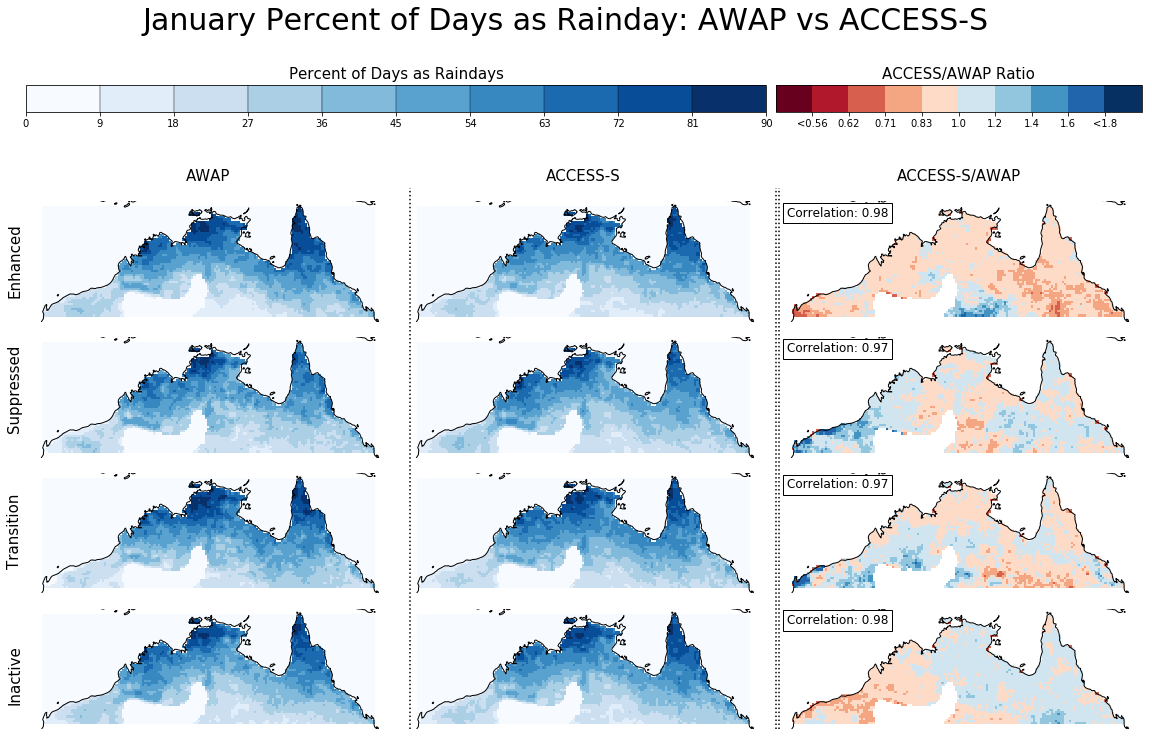

In [46]:
apf = reload(apf) 
apf.comparison_plot(awap_count, access_count_mean, month = 1,
                    plot_max = 90,  vmax = 2, add_white = 0,
                    rain_type = 'Percent of Days as Rainday',
                   cbar1_title = 'Percent of Days as Raindays', cbar2_title = 'ACCESS/AWAP Ratio',
                    savedir = savedir, savefig = 0
                  )

October Percent of Days as Rainday: AWAP vs ACCESS-S has been saved
November Percent of Days as Rainday: AWAP vs ACCESS-S has been saved
December Percent of Days as Rainday: AWAP vs ACCESS-S has been saved
January Percent of Days as Rainday: AWAP vs ACCESS-S has been saved
February Percent of Days as Rainday: AWAP vs ACCESS-S has been saved
March Percent of Days as Rainday: AWAP vs ACCESS-S has been saved


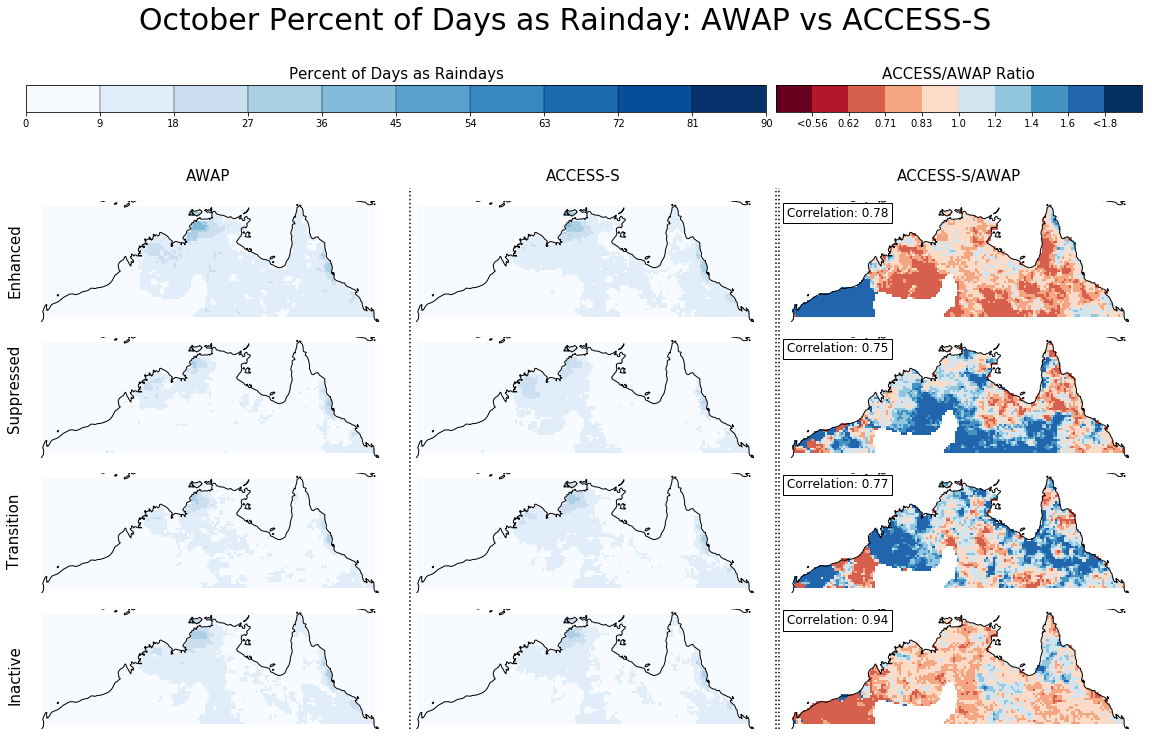

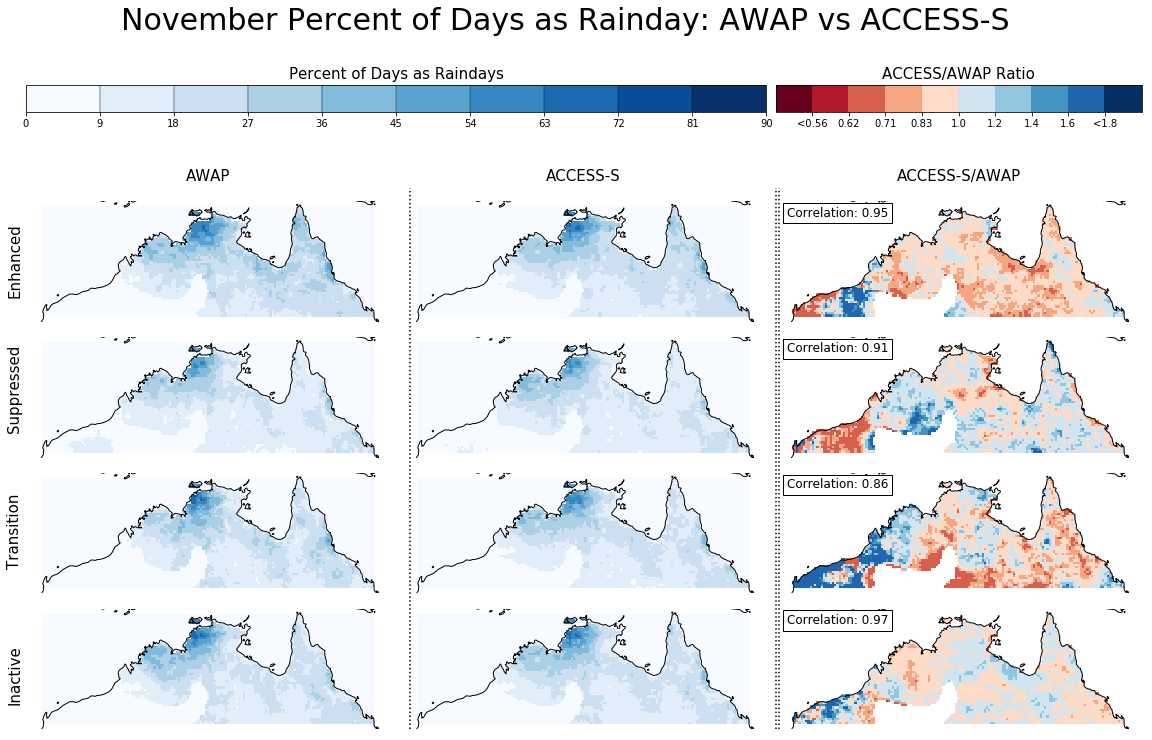

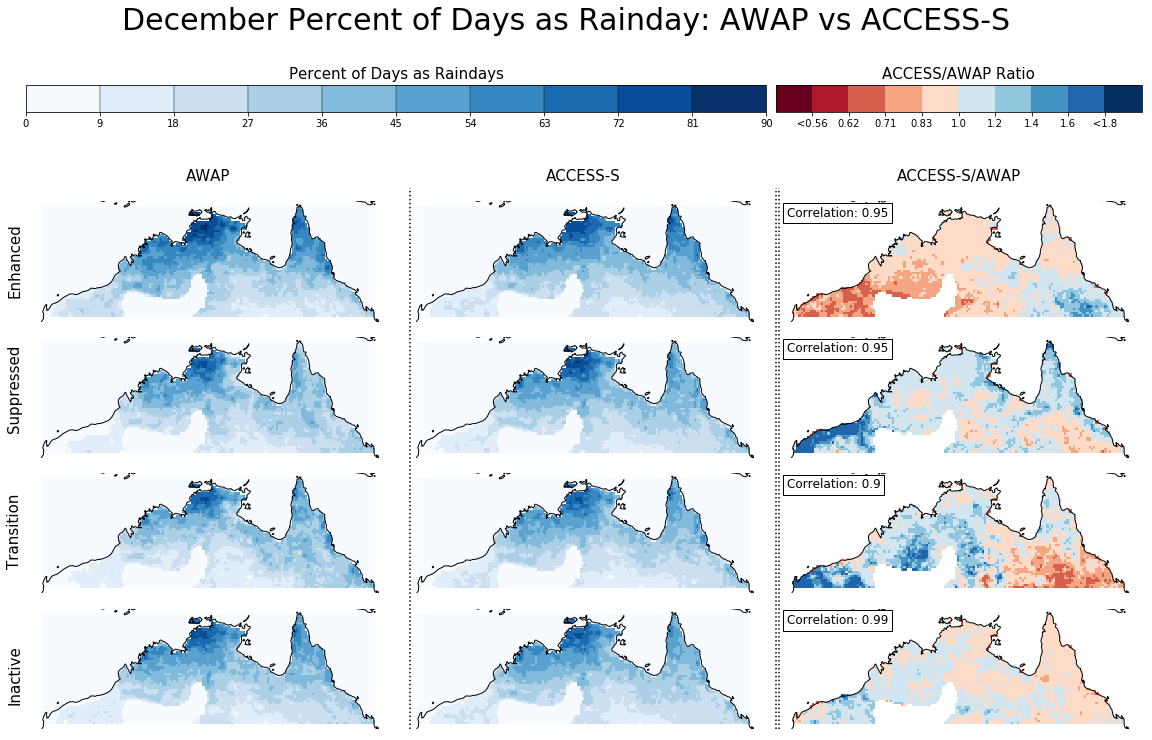

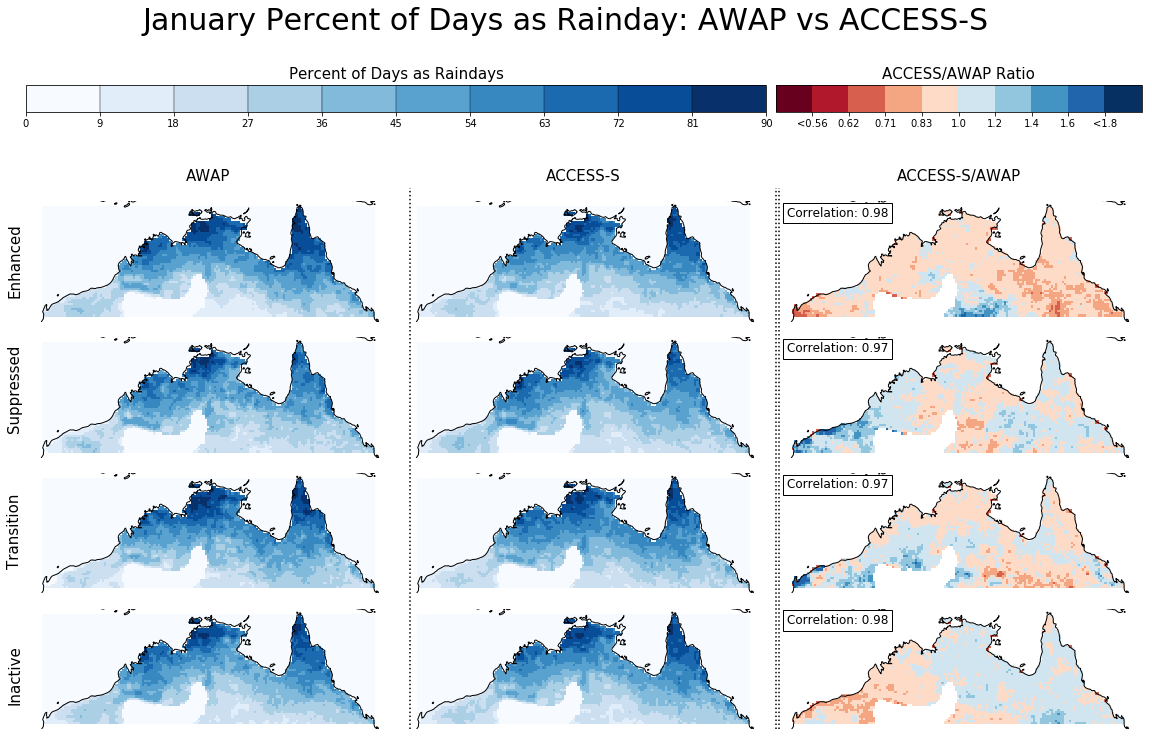

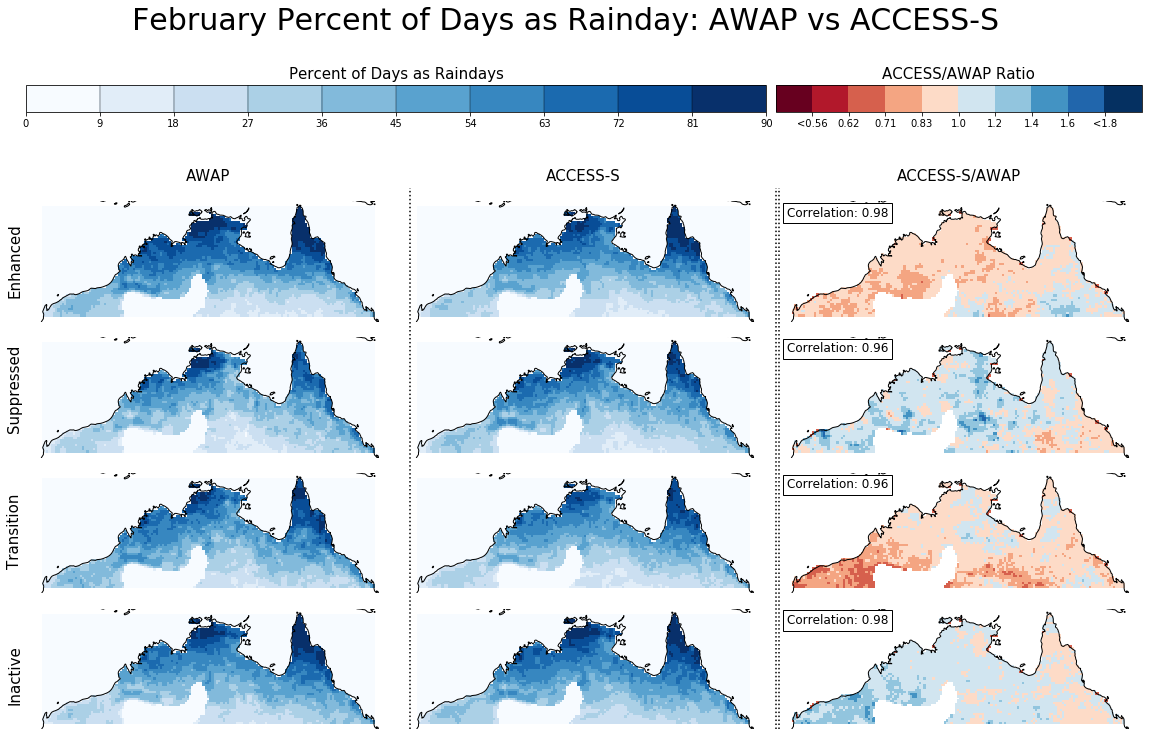

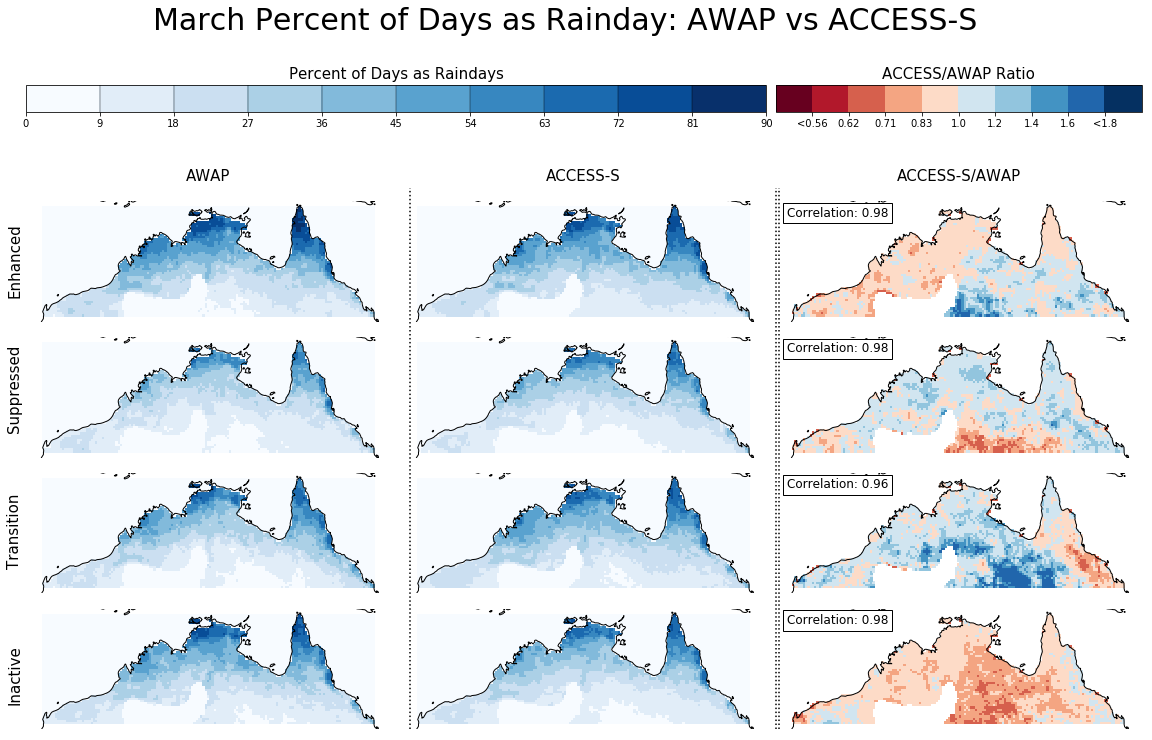

In [76]:
apf = reload(apf) 

for month in [10,11,12,1,2,3]:
    apf.comparison_plot(awap_count, access_count_mean, month = month,
                        plot_max = 90,  vmax = 2, add_white = 0,
                        rain_type = 'Percent of Days as Rainday',
                       cbar1_title = 'Percent of Days as Raindays', cbar2_title = 'ACCESS/AWAP Ratio',
                        savedir = savedir, savefig = 1
                      )

### Anomaly

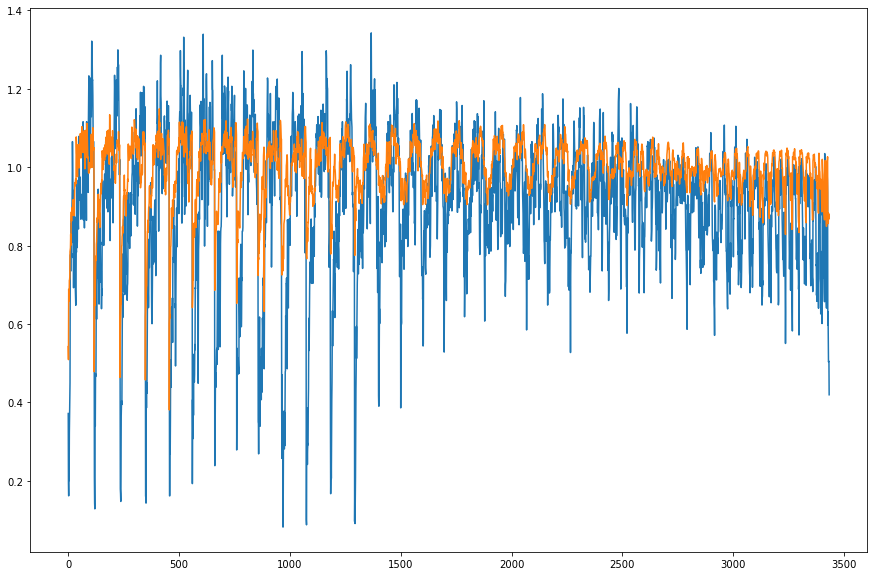

In [51]:
fig = plt.figure(figsize = (15,10))
phase = 'suppressed'
obs = awap_anomaly.sel(month = 12, phase = phase).precip.values.flatten()
mod = access_anom_mean.sel(month = 12, phase = phase).precip.values.flatten()

idx = np.isfinite(obs) & np.isfinite(mod)
obs = obs[idx]
mod = mod[idx]
plt.plot(obs)
plt.plot(mod)

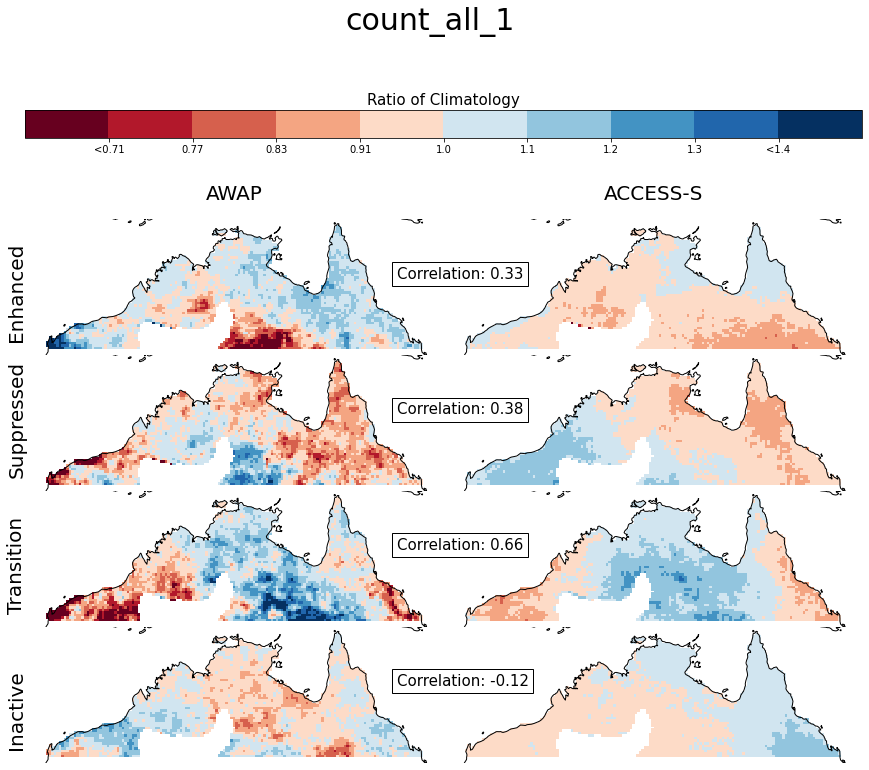

In [35]:
apf = reload(apf)
month = 1
apf.anomaly_plot_subphases(awap_anomaly,access_anom_mean , month = month
                          ,vmax = 1.5, cbar_title = 'Ratio of Climatology',
                          savename = f'count_all_{month}')

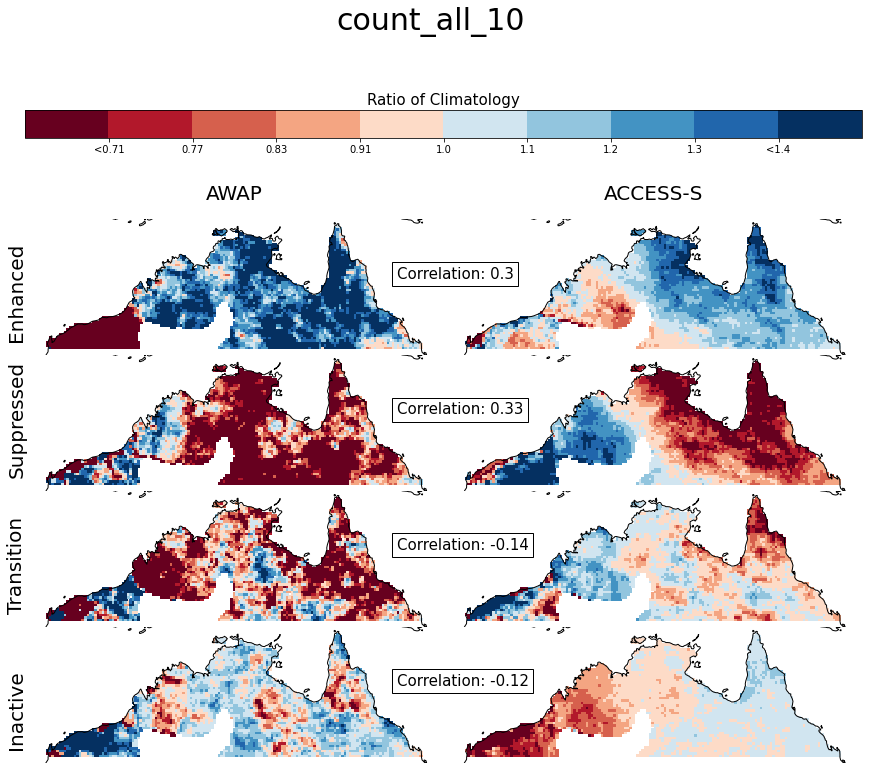

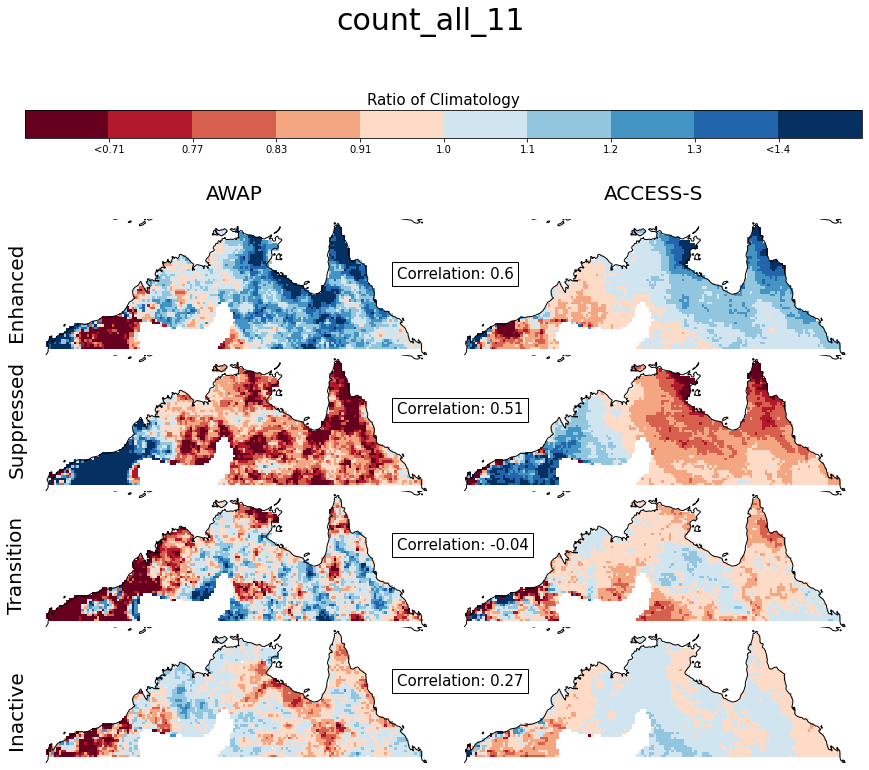

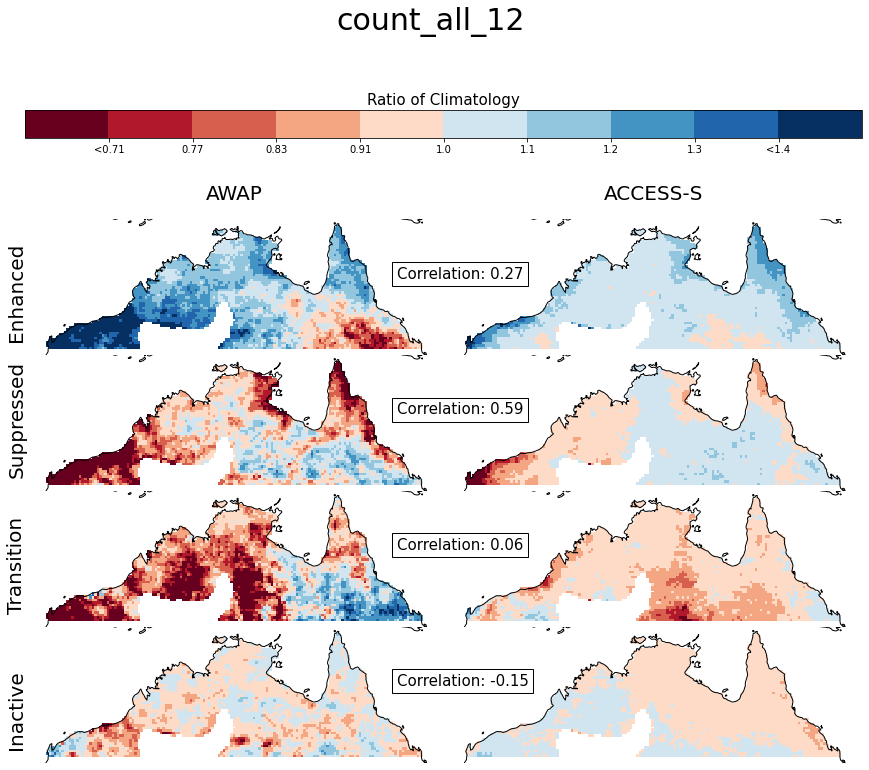

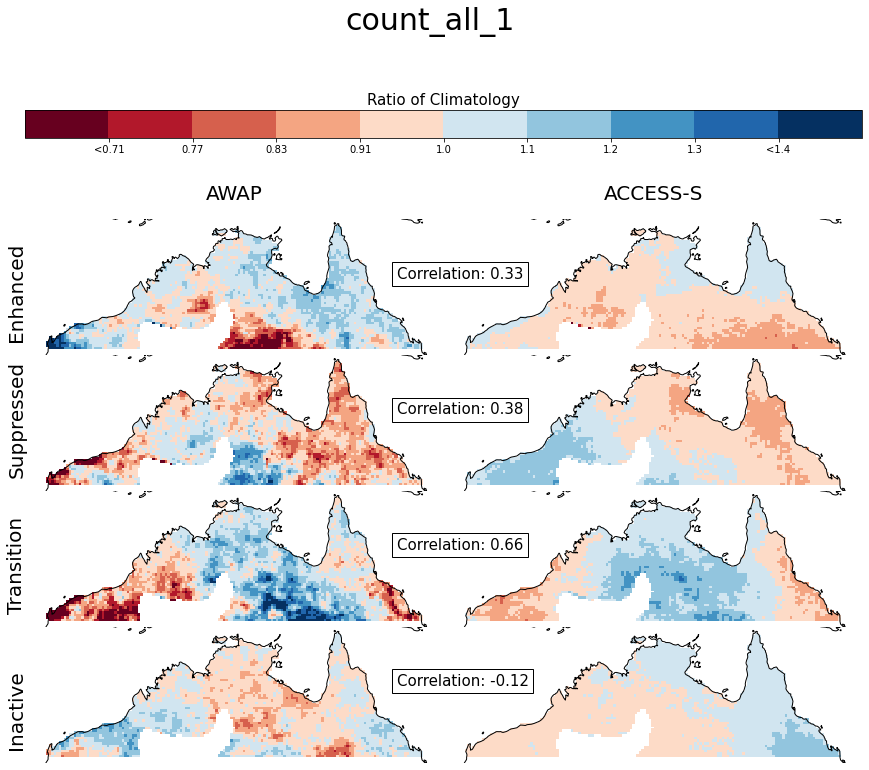

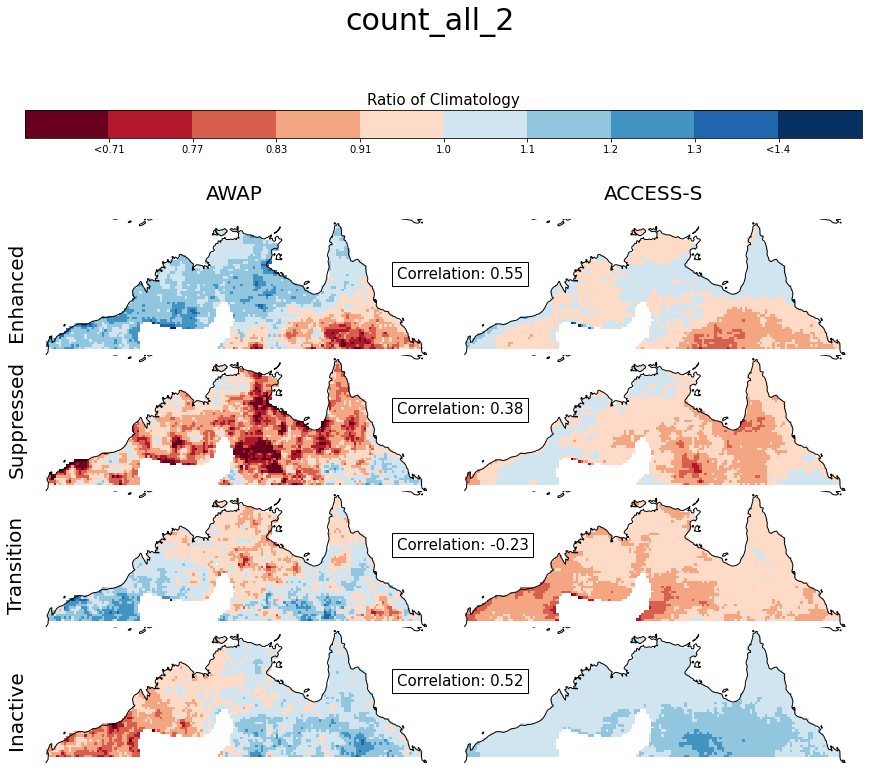

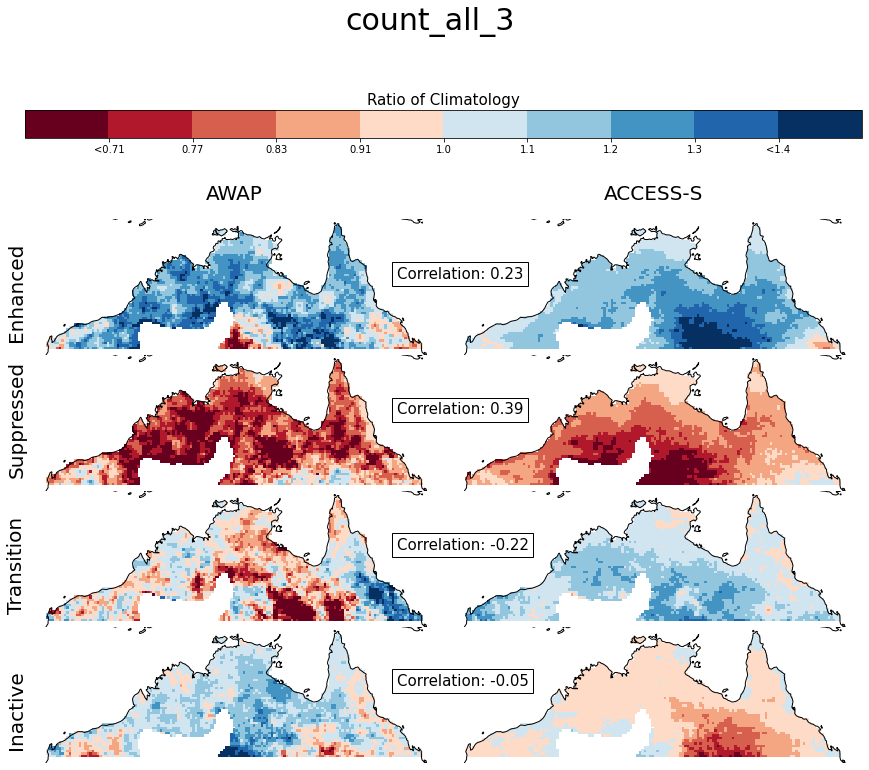

In [41]:
apf = reload(apf)
savedir = '../images/access/pattern_correlation/'
for month in [10,11,12,1,2,3]:

    apf.anomaly_plot_subphases(awap_anomaly,access_anom_mean , month = month
                              ,vmax = 1.5, cbar_title = 'Ratio of Climatology',
                              savename = f'count_all_{month}', savedir =  savedir)


## Timeseries Correlations

### Climatology

In [53]:
af = reload(af)
pattern_correlation = af.month_pattern_correlations(awap_count, access_count_mean)

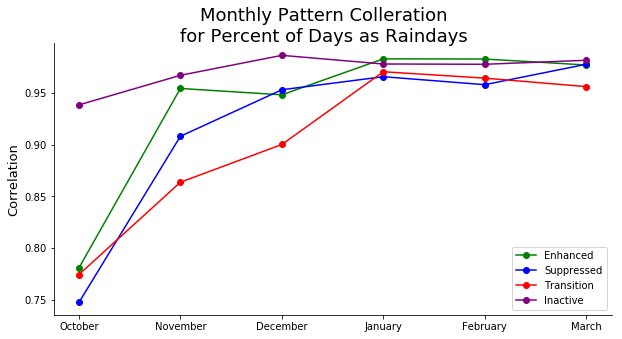

In [73]:
apf = reload(apf)

title = 'Monthly Pattern Colleration\nfor Percent of Days as Raindays'

apf.timeseries_pattern_correlation_plot(pattern_correlation,title = title, custom = 0, savefig = 1, savedir = savedir)

In [58]:
af = reload(af)
ensemble_raw_correlation = af. list_pattern_correlation(awap_count, count_stor)

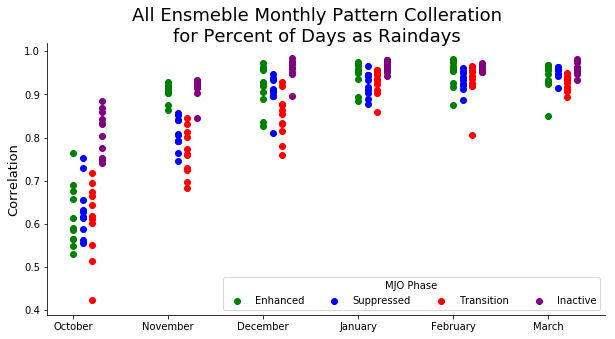

In [71]:
afp2 = reload(afp2)


title = 'All Ensmeble Monthly Pattern Colleration\nfor Percent of Days as Raindays'
afp2.stacked_patter_correlation_timeseries(ensemble_raw_correlation, title = title, savefig = 1, savedir = savedir)

### Anomalies

In [90]:
af = reload(af)
anomaly_patterns = af.month_pattern_correlations(awap_anomaly,access_anom_mean)

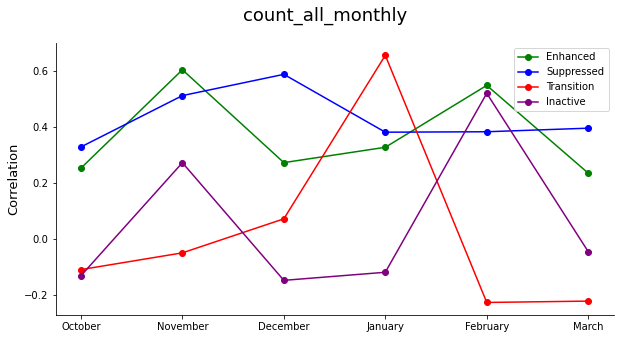

In [89]:
apf = reload(apf)

savename = 'count_all_monthly'

apf.timeseries_pattern_correlation_plot(anomaly_patterns,
                                        custom  = 0, 
                                        savename = savename, savedir = savedir)

<br>
Correlation of the raw count index with awap
<br> <br>
<br>


In [91]:
af = reload(af)
ensemble_anom_correlation = af. list_pattern_correlation(awap_anomaly, anom_stor)

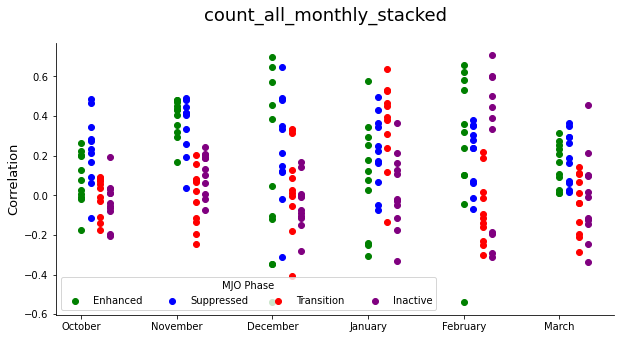

In [92]:
afp2 = reload(afp2)
savename = 'count_all_monthly_stacked'

afp2.stacked_patter_correlation_timeseries(ensemble_anom_correlation, savename = savename,
                                        savedir = savedir)

### Heatmaps

In [11]:
import access_heatmaps_corr as heat_corr

In [12]:
heat_corr = reload(heat_corr)

count_pcorr_all_state = heat_corr.pattern_corr_state(awap_anomaly,access_anom_mean)

In [13]:
count_pcorr_all_state 

<xarray.Dataset>
Dimensions:      (month: 6, phase: 4, state: 4)
Coordinates:
  * month        (month) int64 10 11 12 1 2 3
  * phase        (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * state        (state) object 'All' 'WA' 'NT' 'QLD'
Data variables:
    correlation  (month, phase, state) float64 0.2526 -0.2224 ... 0.05513
    pval         (month, phase, state) float64 1.807e-46 7.938e-09 ... 0.05363

In [15]:
count_pcorr_all_state.to_netcdf('/g/data/w40/ab2313/pattern_correlations/count_pattern_correlation.nc')

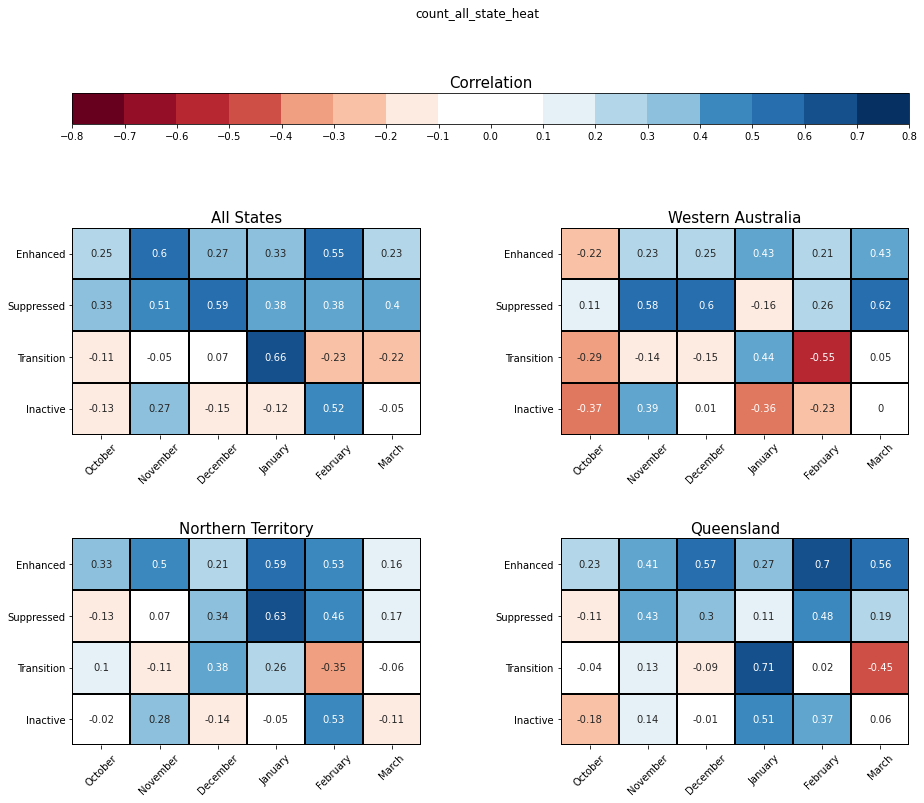

In [135]:
heat_corr = reload(heat_corr)
heat_corr.corr_heatmap_state_group(count_pcorr_all_state.correlation.transpose(), month_reverse = 0
                 , vmax = 0.8,step = 0.1, add_white = 1,
                 savename = 'count_all_state_heat', savedir = savedir)

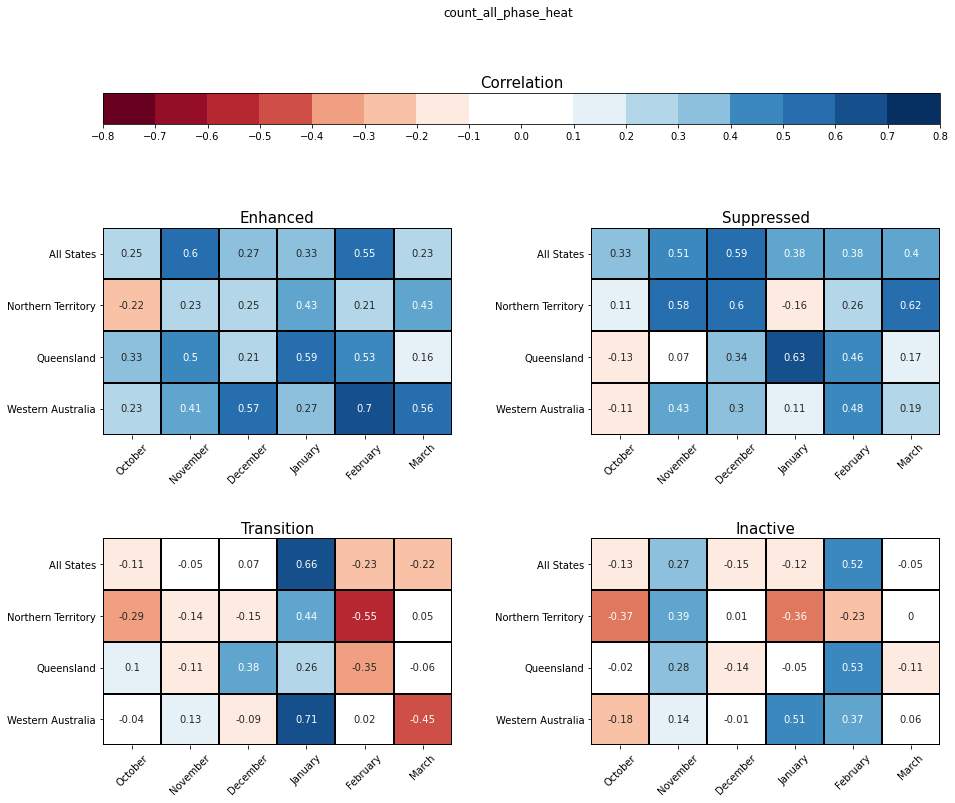

In [134]:
heat_corr = reload(heat_corr)
heat_corr.corr_heatmap_phase_group(count_pcorr_all_state.correlation.transpose(), month_reverse = 0
                 , vmax = 0.8,step = 0.1, add_white = 1
                 ,savename = 'count_all_phase_heat', savedir = savedir)